In [132]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.preprocessing import label_binarize
from scipy import interp

In [133]:
#import our books data
books = pd.read_csv('all_books.csv', index_col=0)

In [134]:
books.head()

,author,title,text
0,austen,Emma-JA,"['volume', 'chapter', 'emma', 'woodhouse', 'ha..."
1,austen,LS-JA,"['lady', 'susan', 'vernon', 'mr', 'vernon', 'l..."
2,austen,Mansfield-JA,"['chapter', 'thirty', 'year', 'ago', 'miss', '..."
3,austen,Northranger_Abbey-JA,"['advertisement', 'authoress', 'northanger', '..."
4,austen,PP_JA,"['chapter', '1', 'truth', 'universally', 'ackn..."


In [135]:
books.author.unique()

array(['austen', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats',
       'melville', 'milton', 'poe', 'shakespeare', 'twain', 'wilde'],
      dtype=object)

In [136]:
bookvect = CountVectorizer()

In [137]:
# count vectorize all the text of books
X_train_counts = bookvect.fit_transform(books['text'])

In [138]:
X_train_counts

<193x104556 sparse matrix of type '<class 'numpy.int64'>'
	with 683367 stored elements in Compressed Sparse Row format>

In [139]:
tdif = TfidfVectorizer()

In [140]:
# run TD-IDF on the data
tdif_matrix = tdif.fit_transform(books['text'])

In [141]:
tdif_matrix

<193x104556 sparse matrix of type '<class 'numpy.float64'>'
	with 683367 stored elements in Compressed Sparse Row format>

In [142]:
# set the target to predict authors
target = books.author

In [143]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train_counts, target, stratify=target)

In [144]:
# run naive bayes on training data
clf = GaussianNB()
clf.fit(X_train.todense(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [145]:
# run naive bayes on testing data
preds = clf.predict(X_test.todense())

In [146]:
# let's see how our model did
print(classification_report(y_test, clf.predict(X_test.todense())))

#not so great, but much better then random guessing

              precision    recall  f1-score   support

      austen       1.00      0.50      0.67         2
     dickens       0.33      0.40      0.36         5
       doyle       1.00      0.40      0.57         5
     emerson       0.75      1.00      0.86         3
   hawthorne       1.00      0.33      0.50         3
       keats       1.00      0.50      0.67         4
    melville       0.38      1.00      0.55         3
      milton       1.00      1.00      1.00         3
         poe       0.00      0.00      0.00         4
 shakespeare       1.00      0.78      0.88         9
       twain       0.27      0.75      0.40         4
       wilde       0.75      0.75      0.75         4

   micro avg       0.61      0.61      0.61        49
   macro avg       0.71      0.62      0.60        49
weighted avg       0.72      0.61      0.61        49



/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


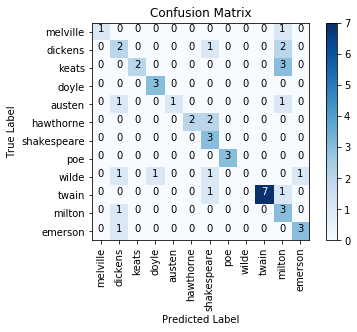

In [147]:
# function to plot confusion matrix 
def show_cf(y_true, y_pred, class_names=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names, rotation='vertical')
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

# call function to plot confusion matrix from our model
show_cf(y_test, preds)

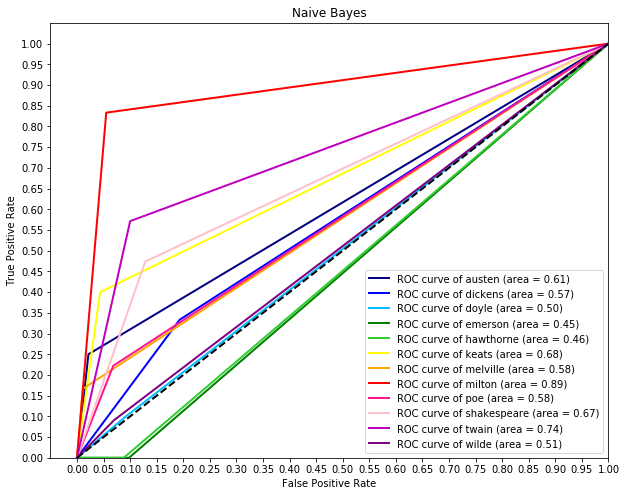

In [148]:
#Plot AUC

X = X_train_counts.todense()
y = target

# Binarize the output
y = label_binarize(y, classes=['austen', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats',
       'melville', 'milton', 'poe', 'shakespeare', 'twain', 'wilde'])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

classifier = OneVsRestClassifier(GaussianNB())
y_score = classifier.fit(X_train, y_train).predict(X_test)
classes=['austen', 'dickens', 'doyle', 'emerson', 'hawthorne', 'keats',
       'melville', 'milton', 'poe', 'shakespeare', 'twain', 'wilde']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['navy', 'blue', 'deepskyblue', 'green', 'limegreen', 'yellow', 'orange', 'red', 'deeppink', 'pink', 'm', 'purple'])
plt.figure(figsize=(10,8))
for i, color,cl in zip(range(n_classes), colors,classes):
    plt.plot(fpr[i], tpr[i], color=color, linewidth=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(cl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes')
plt.legend(loc="lower right")
plt.show()

In [149]:
# now run same model with IDF instead of TF
X_train, X_test, y_train, y_test = train_test_split(tdif_matrix, target, stratify=target)

In [150]:
# train model
clf.fit(X_train.todense(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [151]:
# run model
preds = clf.predict(X_test.todense())

In [152]:
# let's see how it did
print(classification_report(y_test, clf.predict(X_test.todense())))

              precision    recall  f1-score   support

      austen       1.00      0.50      0.67         2
     dickens       0.36      0.80      0.50         5
       doyle       0.00      0.00      0.00         5
     emerson       0.75      1.00      0.86         3
   hawthorne       0.00      0.00      0.00         3
       keats       0.00      0.00      0.00         4
    melville       0.21      1.00      0.35         3
      milton       1.00      0.33      0.50         3
         poe       0.00      0.00      0.00         4
 shakespeare       0.86      0.67      0.75         9
       twain       0.44      1.00      0.62         4
       wilde       1.00      0.50      0.67         4

   micro avg       0.49      0.49      0.49        49
   macro avg       0.47      0.48      0.41        49
weighted avg       0.47      0.49      0.43        49



/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [153]:
#this preformed even worse overall, but milton did way better

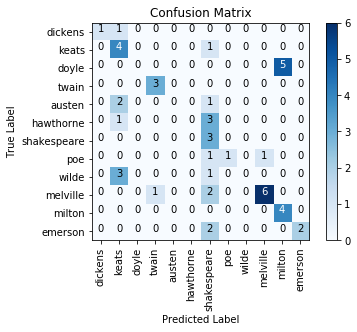

In [154]:
# show confusion matrix
show_cf(y_test, preds)

In [155]:
#we added more data to all_books, lets see how it does with additional data
books = pd.read_csv('all_books_more.csv', index_col=0)

In [156]:
books.head()

,author,title,text
0,austen,Emma-JA,"['volume', 'chapter', 'emma', 'woodhouse', 'ha..."
1,austen,LS-JA,"['lady', 'susan', 'vernon', 'mr', 'vernon', 'l..."
2,austen,Mansfield-JA,"['chapter', 'thirty', 'year', 'ago', 'miss', '..."
3,austen,Northranger_Abbey-JA,"['advertisement', 'authoress', 'northanger', '..."
4,austen,PP_JA,"['chapter', '1', 'truth', 'universally', 'ackn..."


In [157]:
books.shape

(239, 3)

In [158]:
# count vectorize all the text of books
X_train_counts = bookvect.fit_transform(books['text'])

In [159]:
# set target as authors
target = books.author

In [160]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train_counts, target, stratify=target)

In [161]:
# train model
clf.fit(X_train.todense(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [162]:
# run model
preds = clf.predict(X_test.todense())

In [163]:
# let's see how we did this time
print(classification_report(y_test, clf.predict(X_test.todense())))

              precision    recall  f1-score   support

      austen       0.00      0.00      0.00         2
     carroll       1.00      0.33      0.50         3
     dickens       0.00      0.00      0.00         5
       doyle       1.00      0.20      0.33         5
     emerson       0.75      1.00      0.86         3
   hawthorne       0.00      0.00      0.00         3
       keats       0.67      0.50      0.57         4
    melville       0.22      0.67      0.33         3
      milton       1.00      0.33      0.50         3
         poe       0.00      0.00      0.00         4
 shakespeare       0.88      0.78      0.82         9
     thoreau       1.00      0.50      0.67         2
       twain       0.30      0.75      0.43         4
       wells       0.27      1.00      0.43         3
     wharton       1.00      0.67      0.80         3
       wilde       0.50      0.50      0.50         4

   micro avg       0.47      0.47      0.47        60
   macro avg       0.54   

/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lrsterngmail.com/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [164]:
# Adding additiontal authors made the model preform worse 
# it went from 61% to 47%